In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('SMSSpamCollection', sep = '\\t', header=None, names=['label', 'message'])
df.head()

/tmp/ipykernel_4983/63659436.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('SMSSpamCollection', sep = '\\t', header=None, names=['label', 'message'])


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5574, 2)

In [4]:
df.columns.tolist()

['label', 'message']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5574 non-null   object
 1   message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df['label'].value_counts()

label
ham     4827
spam     747
Name: count, dtype: int64

## Label Encoding

In [7]:
df['label_num'] = df['label'].map({'ham':0, 'spam':1})

In [8]:
df[['label', 'label_num']].head()

,label,label_num
0,ham,0
1,ham,0
2,spam,1
3,ham,0
4,ham,0


In [9]:
df['label_num'].value_counts()

label_num
0    4827
1     747
Name: count, dtype: int64

## Text Cleanning and NLP Preprocessing

In [10]:
df.isnull().sum()

label        0
message      0
label_num    0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(414)

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
## import libraries
import nltk 
import string 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [14]:
# download required resources 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/sabin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sabin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sabin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [16]:
def clean_text(text): 
    #lowercase
    text = text.lower()

    #remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])

    #tokenize 
    words = word_tokenize(text)

    # remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ''.join(cleaned)

In [17]:
df['clean_message'] = df['message'].apply(clean_text)

In [18]:
df[['message', 'clean_message']].head()

,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",gojurongpointcrazyavailablebugisngreatworldlae...
1,Ok lar... Joking wif u oni...,oklarjokingwifuoni
2,Free entry in 2 a wkly comp to win FA Cup fina...,freeentry2wklycompwinfacupfinaltkts21stmay2005...
3,U dun say so early hor... U c already then say...,udunsayearlyhorucalreadysay
4,"Nah I don't think he goes to usf, he lives aro...",nahdontthinkgousflifearoundthough


## Featrue Extraction (Vectorization)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,3))

In [21]:
x = tfidf.fit_transform(df['clean_message']).toarray()
y = df['label_num']

## Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, stratify=y)

In [24]:
x_train.shape, y_train.shape

((4128, 3000), (4128,))

In [25]:
x_test.shape, y_test.shape

((1032, 3000), (1032,))

# Model Buildings

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [27]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1)
lr.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [28]:
lr.score(x_train, y_train)*100, lr.score(x_test, y_test)*100

(95.51841085271317, 89.34108527131784)

In [29]:
accuracy_score(y_test, lr.predict(x_test))

0.8934108527131783

In [30]:
confusion_matrix(y_test, lr.predict(x_test))

array([[904,   0],
       [110,  18]])

In [31]:
classification_report(y_test, lr.predict(x_test))

'              precision    recall  f1-score   support\n\n           0       0.89      1.00      0.94       904\n           1       1.00      0.14      0.25       128\n\n    accuracy                           0.89      1032\n   macro avg       0.95      0.57      0.59      1032\nweighted avg       0.90      0.89      0.86      1032\n'

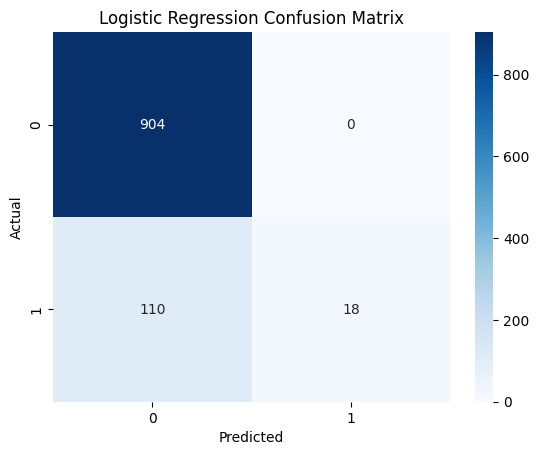

In [32]:
sns.heatmap(confusion_matrix(y_test, lr.predict(x_test)), annot= True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [34]:
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [35]:
y_prd_svc = svc.predict(x_test)

In [36]:
classification_report(y_test, y_prd_svc)

'              precision    recall  f1-score   support\n\n           0       0.88      1.00      0.94       904\n           1       1.00      0.07      0.13       128\n\n    accuracy                           0.88      1032\n   macro avg       0.94      0.54      0.53      1032\nweighted avg       0.90      0.88      0.84      1032\n'

In [37]:
confusion_matrix(y_test, y_prd_svc)

array([[904,   0],
       [119,   9]])

In [38]:
accuracy_score(y_test, y_prd_svc)

0.8846899224806202

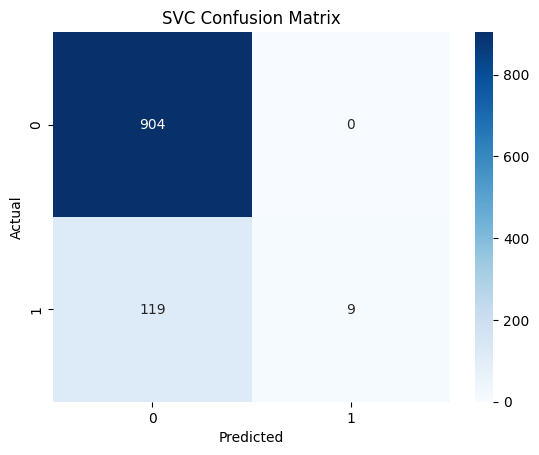

In [39]:
sns.heatmap(confusion_matrix(y_test, y_prd_svc), annot= True, fmt='d', cmap='Blues')
plt.title('SVC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB

In [41]:
mn = MultinomialNB()
mn.fit(x_train, y_train)

MultinomialNB()

In [42]:
mn.score(x_train, y_train)*100, mn.score(x_test, y_test)*100

(88.39631782945736, 87.79069767441861)

In [43]:
mn_pred = mn.predict(x_test)

In [44]:
classification_report(y_test, mn_pred)

'              precision    recall  f1-score   support\n\n           0       0.88      1.00      0.93       904\n           1       1.00      0.02      0.03       128\n\n    accuracy                           0.88      1032\n   macro avg       0.94      0.51      0.48      1032\nweighted avg       0.89      0.88      0.82      1032\n'

In [45]:
cm = confusion_matrix(y_test, mn_pred)
cm

array([[904,   0],
       [126,   2]])

In [46]:
accuracy_score(y_test, mn_pred)

0.877906976744186

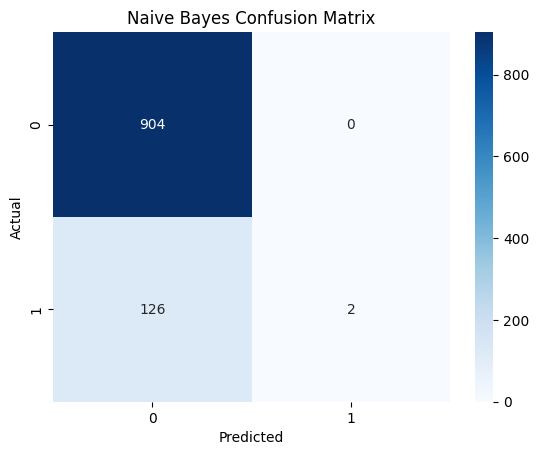

In [47]:
sns.heatmap(cm,  annot= True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Hyperparameter Tuning with GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}

In [50]:
mnb = MultinomialNB()
grid = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 5, 10]},
             scoring='accuracy')

In [51]:
grid.best_params_['alpha']

0.01

In [52]:
grid.best_score_

np.float64(0.905038961038961)

In [53]:
best_mnb = grid.best_estimator_
y_pred = best_mnb.predict(x_test)

In [54]:
accuracy_score(y_test, y_pred)

0.8924418604651163

In [55]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.90      0.99      0.94       904\n           1       0.74      0.20      0.32       128\n\n    accuracy                           0.89      1032\n   macro avg       0.82      0.60      0.63      1032\nweighted avg       0.88      0.89      0.86      1032\n'

In [56]:
confusion_matrix(y_test, y_pred)

array([[895,   9],
       [102,  26]])

## Apply SMOTE to balance the dataset

In [57]:
pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [59]:
smote = RandomOverSampler(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [60]:
Counter(y_train), Counter(y_train_smote)

(Counter({0: 3614, 1: 514}), Counter({0: 3614, 1: 3614}))

## Retrain MultinomailNB on SMOTE data

In [61]:
mn = MultinomialNB()
mn.fit(x_train_smote, y_train_smote)

MultinomialNB()

In [62]:
mn.score(x_train_smote, y_train_smote)*100, mn.score(x_test, y_test)*100

(81.76535694521306, 89.34108527131784)

In [63]:
y_pred_smote = mn.predict(x_test)

In [64]:
confusion_matrix(y_test, y_pred_smote)

array([[904,   0],
       [110,  18]])

## Save the Model

In [65]:
import joblib

In [66]:
# Save Model
joblib.dump(mn, 'spam_model.joblib')

['spam_model.joblib']

In [67]:
# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

## Load the Model

In [68]:
model = joblib.load('spam_model.joblib')
vectorizer = joblib.load('tfidf_vectorizer.joblib')

In [69]:
def clean_text(text):
    import re
    import string
    from nltk.corpus import stopwords

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [70]:
def predict_message(message):
    # Clean message
    cleaned = clean_text(message)
    
    # Vectorize
    vectorized = vectorizer.transform([cleaned])
    
    # Predict
    prediction = model.predict(vectorized)[0]
    
    return 'Spam' if prediction == 1 else 'Ham'


In [71]:
predict_message("Hey, are we still meeting at 5 today?")  # Likely ham

'Ham'